# Connectivity Exploration
This interactive notebook explores differences in connectivity. It is meant to be an interpretable, adaptable, and extendable presentation of results.

If more data is acquired, or pre-processing methodologies are modified, this notebook can simply be re-run to update results.

## Imports and Defining Filepaths

In [15]:
import os
import numpy as np
from results_exploration_helpers import *

# Define directories where connectivity data is stored
root = "/Volumes/eeg" 
expert_dir = os.path.join(root, "connectivity_scores", "expert")
novice_dir = os.path.join(root, "connectivity_scores", "novice")
electrode_names_dir = os.path.join(root, "channel_names.npy")
frequencies_dir = os.path.join(root, "frequencies.npy")

# Load data specifying the channel names and frequencies used
electrode_names = np.load(electrode_names_dir)
frequencies = np.load(frequencies_dir)

## Load Data
All connectivity data is loaded for experts and novices, with and without gestures for baselines and demonstrations yielding a total of 8 variables. Each variable contains a list of length equal to the number of subjects. 

In [16]:
# Load the connectivity data for all conditions and subjects
expert_BL_NoG, expert_BL_WiG, expert_NoG, expert_WiG = load_all_connectivity(expert_dir)
novice_BL_NoG, novice_BL_WiG, novice_NoG, novice_WiG = load_all_connectivity(novice_dir)

# Verify that the number of subjects is the same for all conditions
assert(len(expert_BL_NoG) == len(expert_BL_WiG) == len(expert_NoG) == len(expert_WiG)) 
assert(len(novice_BL_NoG) == len(novice_BL_WiG) == len(novice_NoG) == len(novice_WiG))

# Print the number of experts and novices
print("Number of experts: ", len(expert_BL_NoG))
print("Number of novices: ", len(novice_BL_NoG))

Number of experts:  15
Number of novices:  12


Every list entry (one per subject, per condition combination) is a 4 dimensional numpy array of shape $\mathcal{E}$ x $\mathcal{C} $ x $ \mathcal{C} $ x $ \mathcal{F}$ defined as follows:

$\mathcal{E}$:  Number of epochs isolated for this subject under the current conditions.

$\mathcal{C}$:  Number of electrodes used for connectivity calculation. 12 by default.

$\mathcal{F}$:  Number of distinct frequencies for which connectivity values have been calculated. 60 by default corresponding to [0.5hz, 30hz] in 0.5hz increments.


In [17]:
# Print the shape of the data for the first expert subject in the BL_NoG condition
print("Shape of data: ", expert_BL_NoG[0].shape)

# Verify that the data has the expected shape
assert(expert_BL_NoG[0].shape[1] == expert_BL_NoG[0].shape[2] == len(electrode_names)) # Dimensions 1,2 should equal the number of electrodes
assert(expert_BL_NoG[0].shape[3] == len(frequencies)) # Dimension 3 should equal the number of frequencies

Shape of data:  (41, 12, 12, 60)


## Split Data for Mixed-design ANOVA
The data must now be partitioned into groups based on expert/novice status OR usage of gestures. Within each group, there should be a baseline dataset and a demonstration dataset.

In [18]:
# If true, group A is all expert data, group B is all novice data. If False, group A is all NoG data, group B is all WiG data
split_on_expertise = False 
join_groups = join_groups_naive# TODO: Discuss if join_groups_epoch_averaging is more appropriate


if split_on_expertise:
    # Group A is all expert data, group B is all novice data
    group_a_BL_data = join_groups(expert_BL_NoG, expert_BL_WiG)
    group_a_demo_data = join_groups(expert_NoG, expert_WiG)

    group_b_BL_data = join_groups(novice_BL_NoG, novice_BL_WiG)
    group_b_demo_data = join_groups(novice_NoG, novice_WiG)
else: # Split on gesturing
    # Group A is all NoG data, group B is all WiG data
    group_a_BL_data = join_groups(expert_BL_NoG, novice_BL_NoG)
    group_a_demo_data = join_groups(expert_NoG, novice_NoG)

    group_b_BL_data = join_groups(expert_BL_WiG, novice_BL_WiG)
    group_b_demo_data = join_groups(expert_WiG, novice_WiG)


In [27]:
print("Number of group A samples: ", len(group_a_BL_data))
print("Number of group B samples: ", len(group_a_BL_data))

Number of group A samples:  27
Number of group B samples:  27


## Average Over Epochs
To simplify our data, for every subject, compute the average connectivity across all epochs. 

This will reduce the dimensionality of the data from $\mathcal{E}$ x $\mathcal{C} $ x $ \mathcal{C} $ x $ \mathcal{F}$  to just $\mathcal{C} $ x $ \mathcal{C} $ x $ \mathcal{F}$

In [20]:
group_a_BL_data = average_over_dimension(group_a_BL_data, 0)
group_a_demo_data = average_over_dimension(group_a_demo_data, 0)
group_b_BL_data = average_over_dimension(group_b_BL_data, 0)
group_b_demo_data = average_over_dimension(group_b_demo_data, 0)

# Print the shape of the data for the first expert subject in the BL_NoG condition
print("Shape of data for a single subject: ", group_a_BL_data[0].shape)

Shape of data for a single subject:  (12, 12, 60)


## Combine into a single Numpy Array
Now, that data for all subjects have the same shape, the lists of subjects can be converted to numpy arrays.

The data will now be of shape $\mathcal{N}$ x $\mathcal{C} $ x $ \mathcal{C} $ x $ \mathcal{F}$ where $\mathcal{N}$ is the number of subjects in that group.

In [21]:
group_a_BL = np.array(group_a_BL_data)
group_b_BL = np.array(group_b_BL_data)
group_a_demo = np.array(group_a_demo_data)
group_b_demo = np.array(group_b_demo_data)

# Print all shapes
print(group_a_BL.shape)
print(group_b_BL.shape)
print(group_a_demo.shape)
print(group_b_demo.shape)


(27, 12, 12, 60)
(27, 12, 12, 60)
(27, 12, 12, 60)
(27, 12, 12, 60)


## Average Over Frequency Bands

To further simplify the data, we take a slice of the data along its last dimension (frequencies) and compute a single average. The code below generates four variants of our groups corresponding to averages over the delta, theta, low alpha and high alpha wavelengths.

The resulting arrays will have shape $\mathcal{N}$ x $\mathcal{C} $ x $ \mathcal{C} $ and represent the average connectivity for a single frequency band.

In [22]:
groups = (group_a_BL, group_a_demo, group_b_BL, group_b_demo)
delta_groups = get_frequency_groups(groups, frequencies, 0.5, 4.0)
theta_groups = get_frequency_groups(groups, frequencies, 4.0, 8.0)
low_alpha_groups = get_frequency_groups(groups, frequencies, 8.0, 13.0)
high_alpha_groups = get_frequency_groups(groups, frequencies, 13.0, 30.0)

print("Example shape for group A Baseline data: ", delta_groups[0].shape)

Example shape for group A Baseline data:  (27, 12, 12)


## Run Mixed Anova
The following code performs Mixed Anova using the [implementation provided by the Pengouin Stats Library](https://pingouin-stats.org/build/html/generated/pingouin.mixed_anova.html).

Currently, it just returns Group, Condition and Interaction P values. Pengouin provides far more values and these functions could be easily extended to include other needed values.

In [23]:
delta_ps = generate_anova_p_values(delta_groups)
theta_ps = generate_anova_p_values(theta_groups)
low_alpha_ps = generate_anova_p_values(low_alpha_groups)
high_alpha_ps = generate_anova_p_values(high_alpha_groups)

## Plot Results

The plotting utilities present p values in a heatmap format for Group, Condition and Interaction. For any p value <= 0.05, the exact value is included in the corresponding cell to quickly identify significant results.

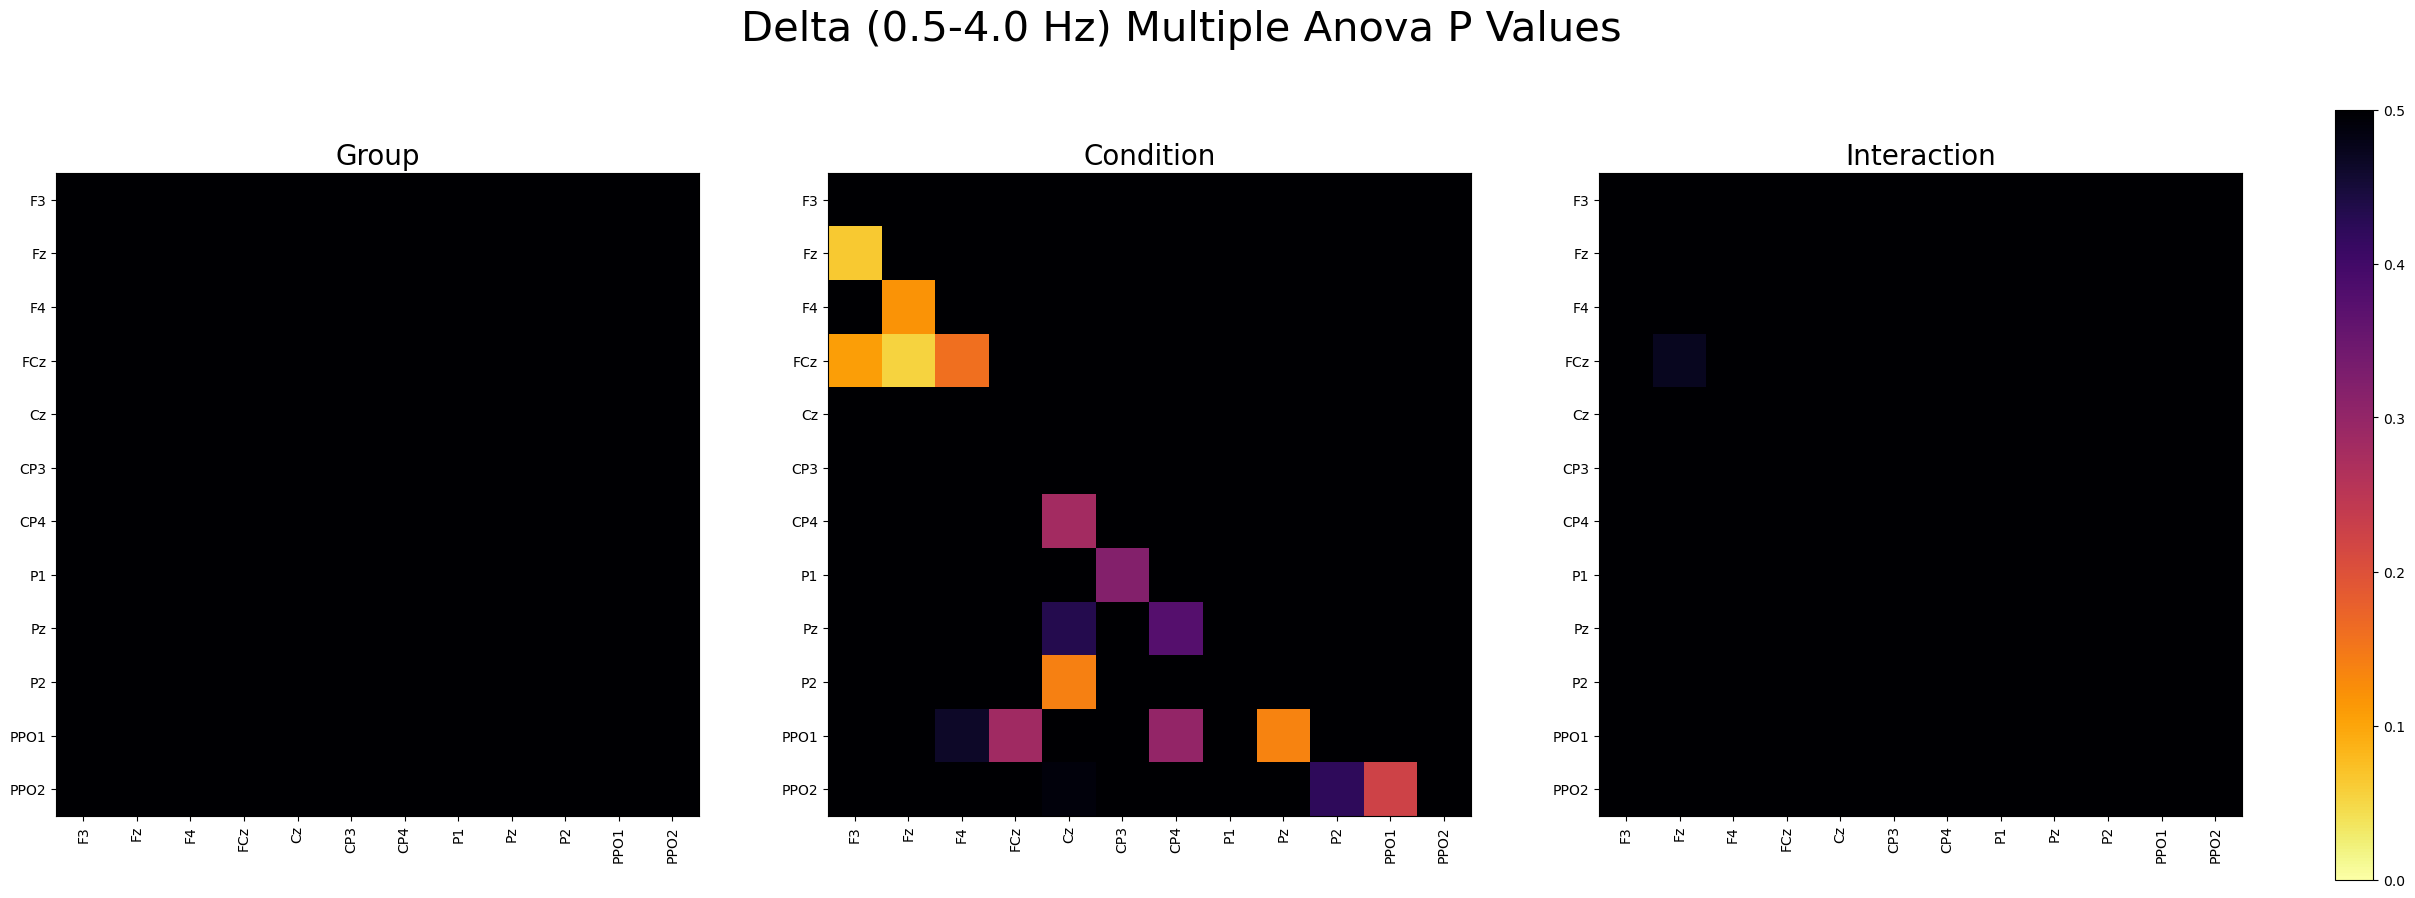

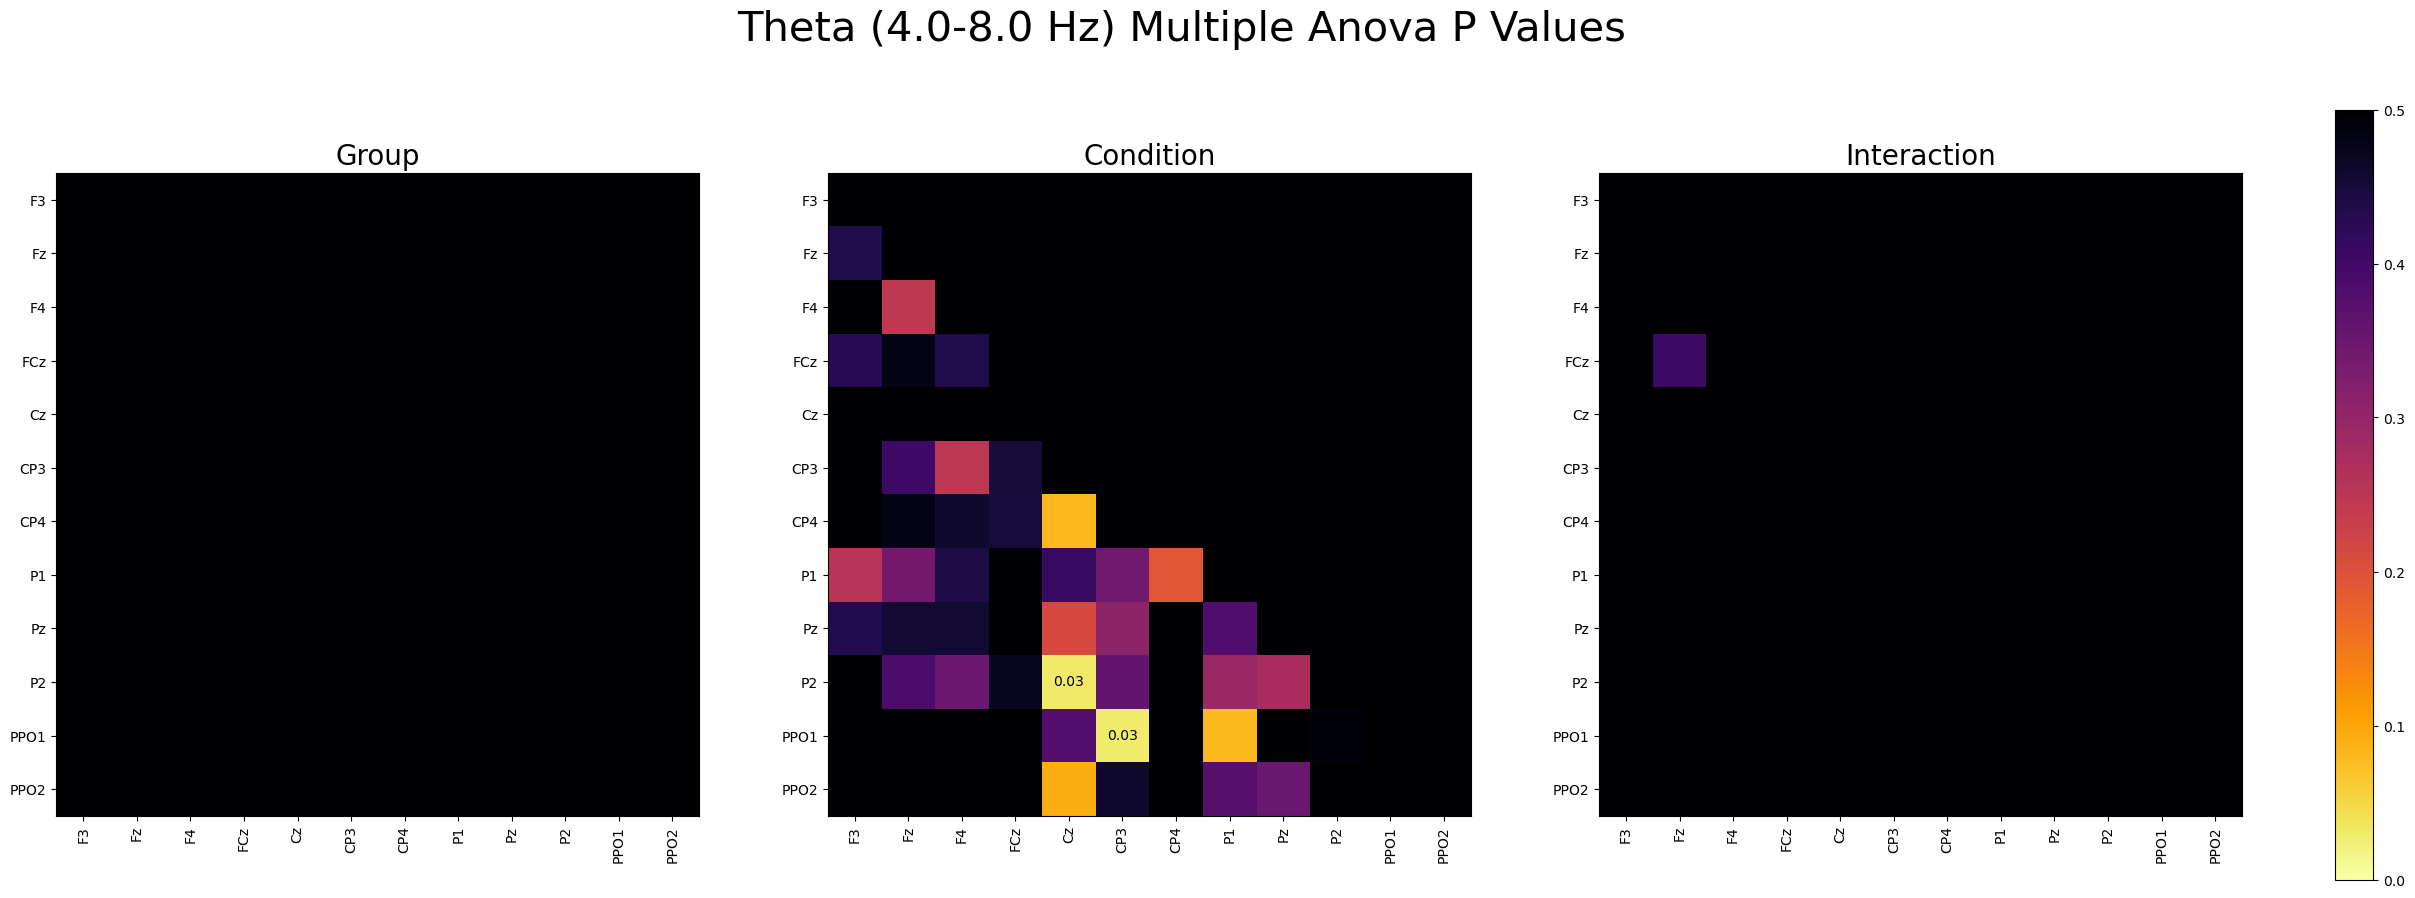

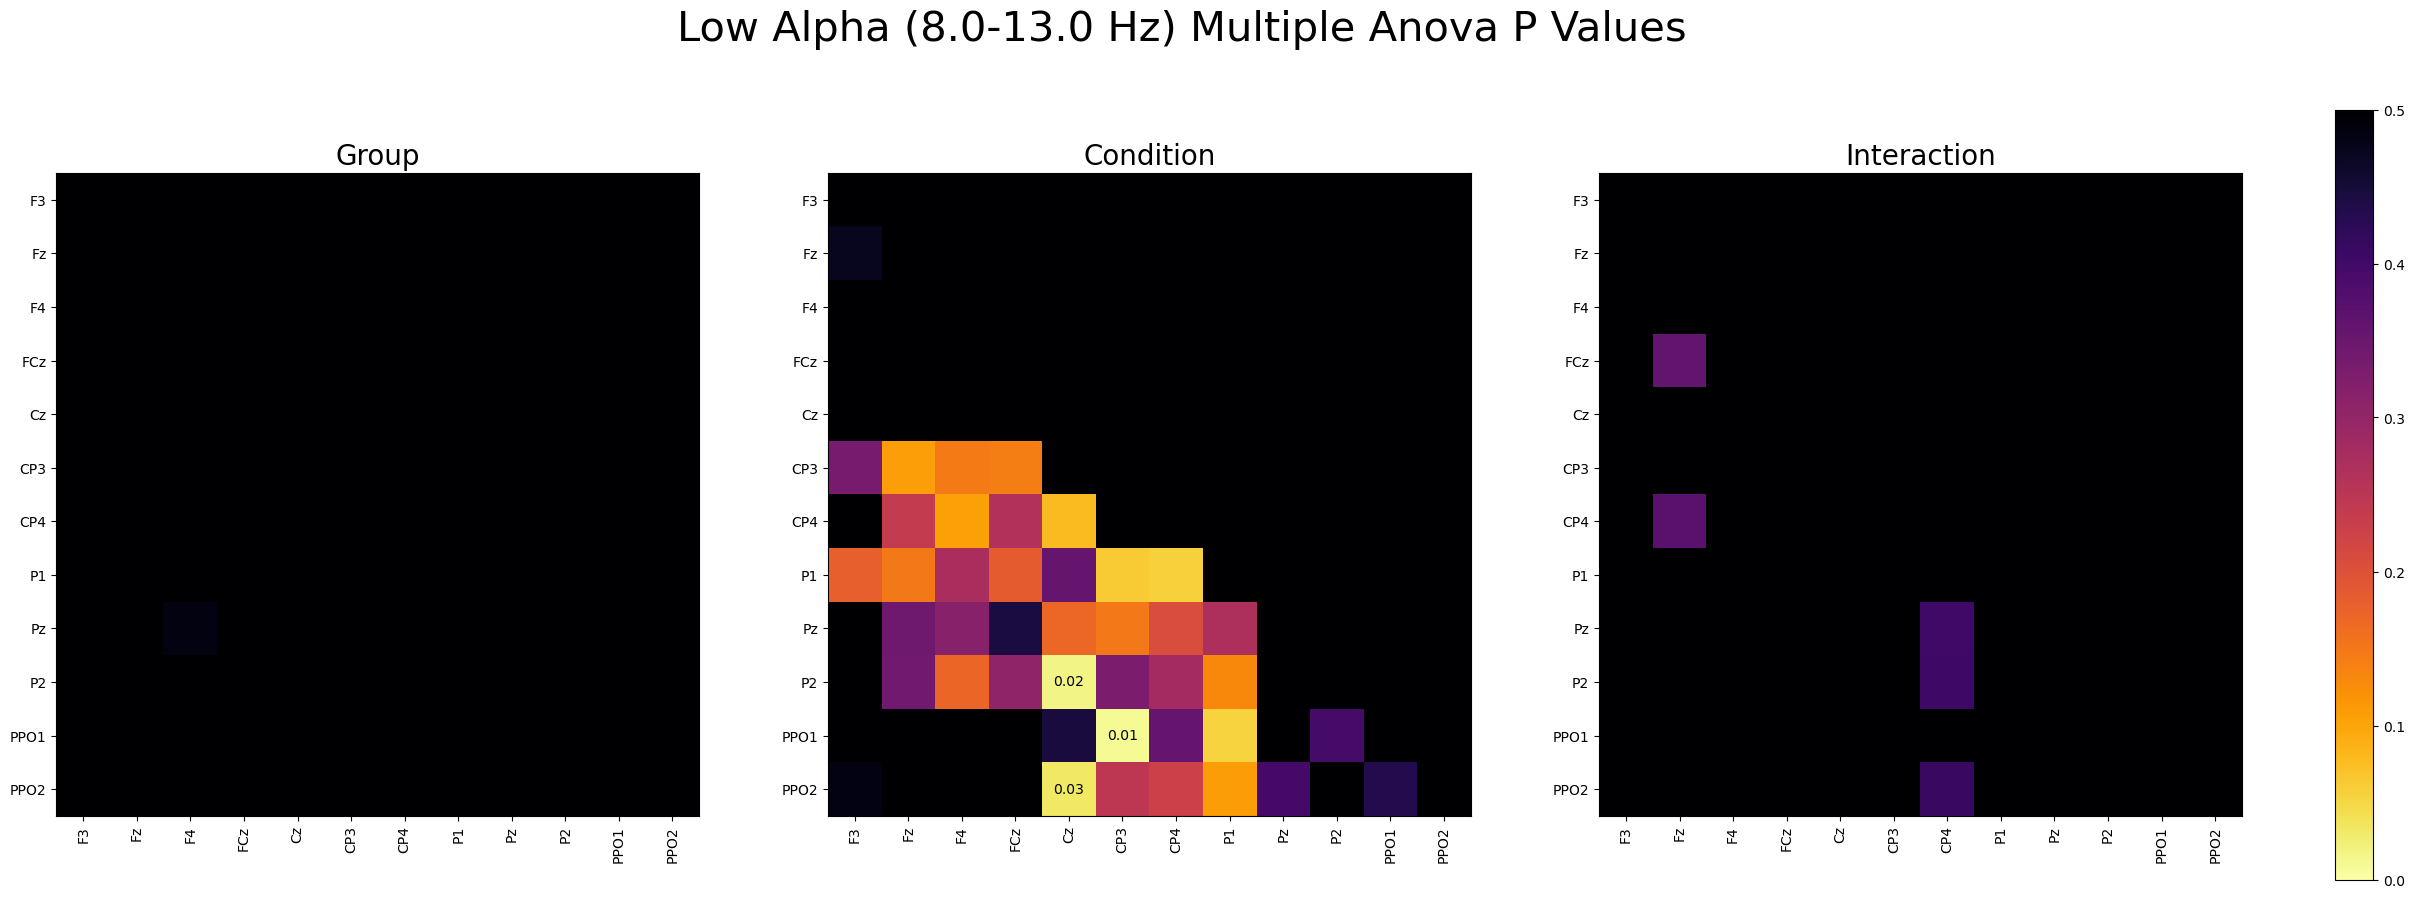

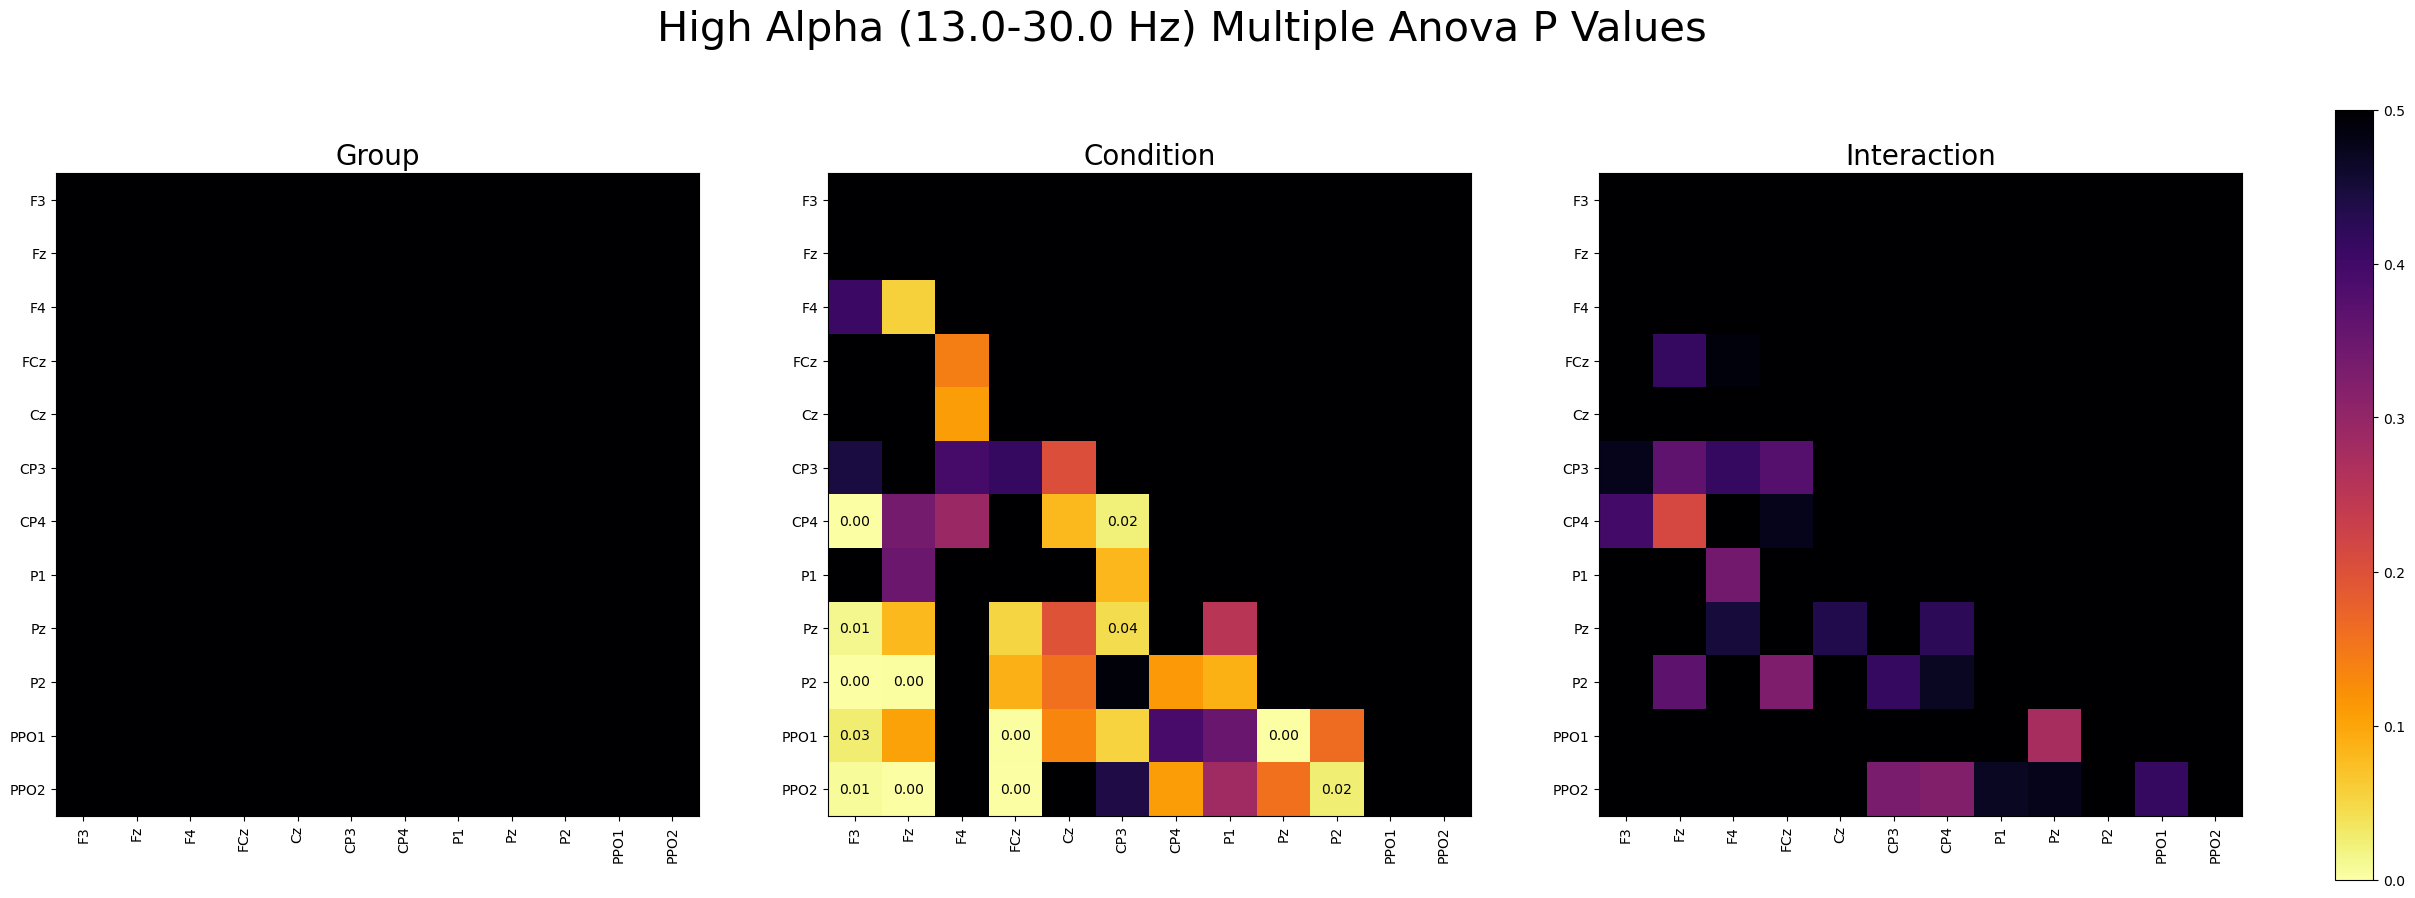

In [24]:
plot_ps(delta_ps, electrode_names, "Delta (0.5-4.0 Hz) Multiple Anova P Values")
plot_ps(theta_ps, electrode_names, "Theta (4.0-8.0 Hz) Multiple Anova P Values")
plot_ps(low_alpha_ps, electrode_names, "Low Alpha (8.0-13.0 Hz) Multiple Anova P Values")
plot_ps(high_alpha_ps, electrode_names, "High Alpha (13.0-30.0 Hz) Multiple Anova P Values")

In [25]:
# Compute group means for all four groups
delta_group_means = get_group_means(delta_groups)
theta_group_means = get_group_means(theta_groups)
low_alpha_group_means = get_group_means(low_alpha_groups)
high_alpha_group_means = get_group_means(high_alpha_groups)

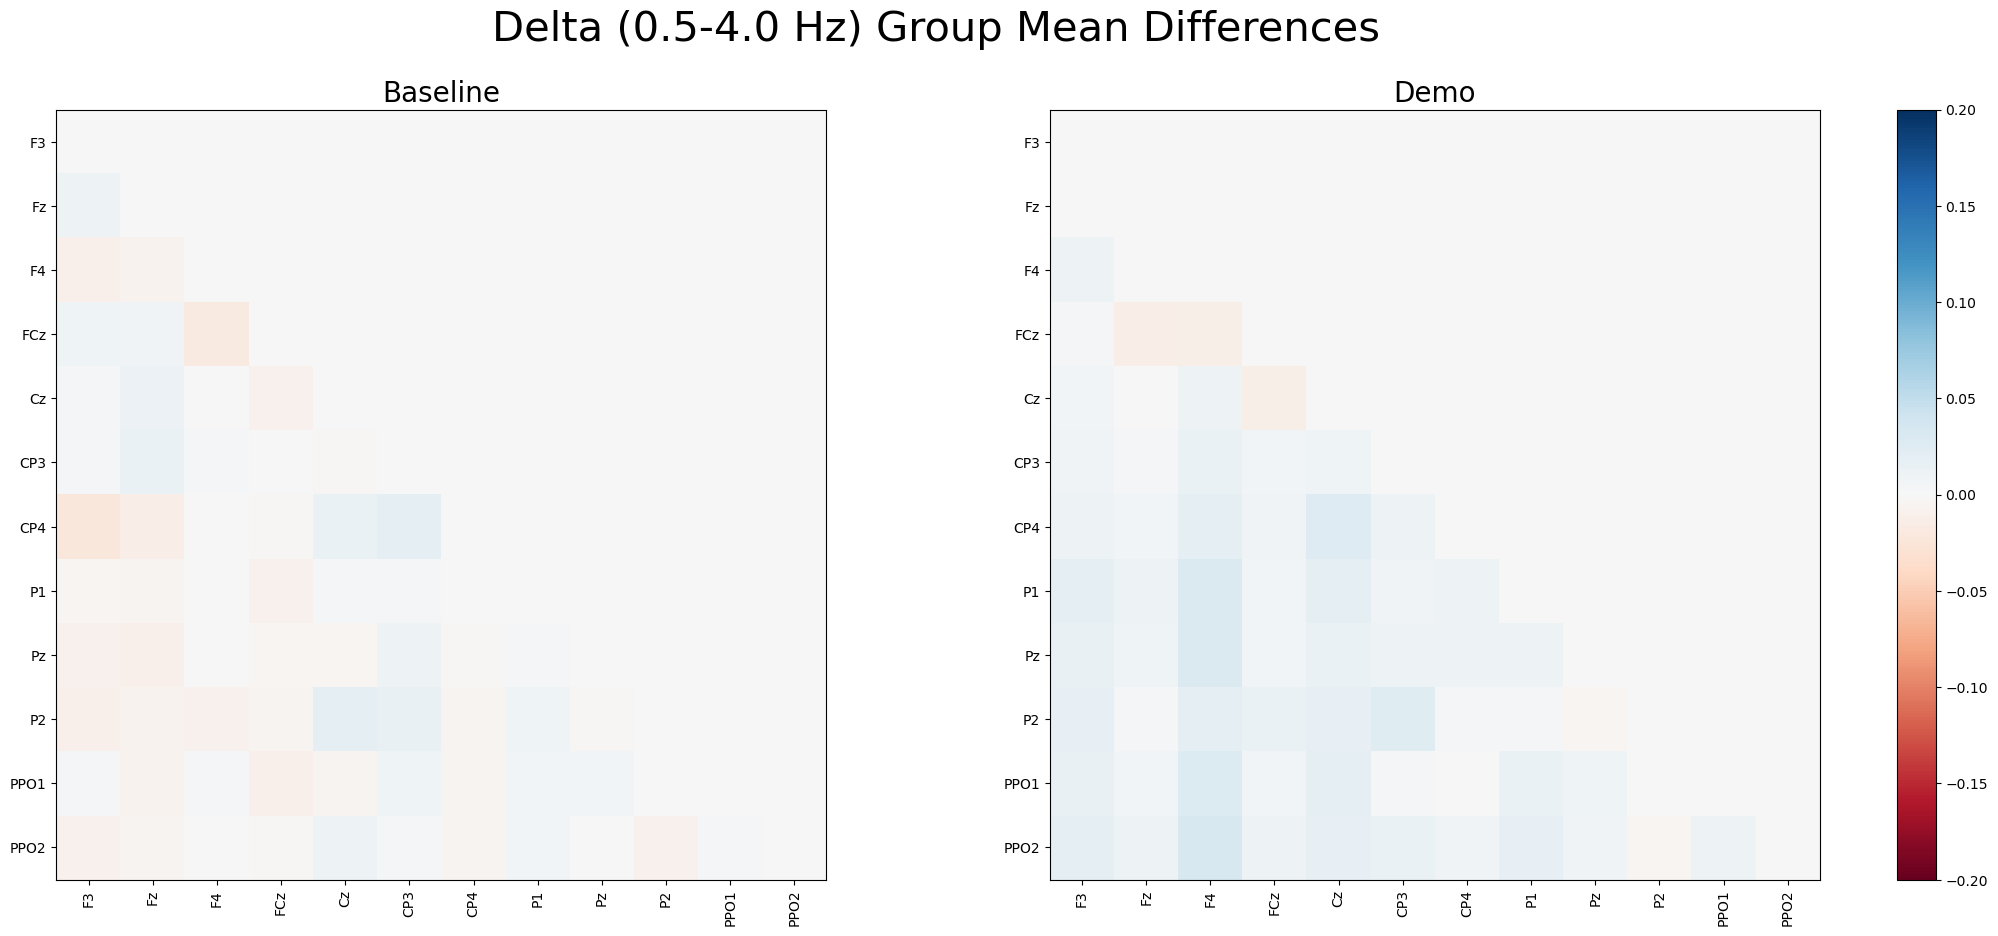

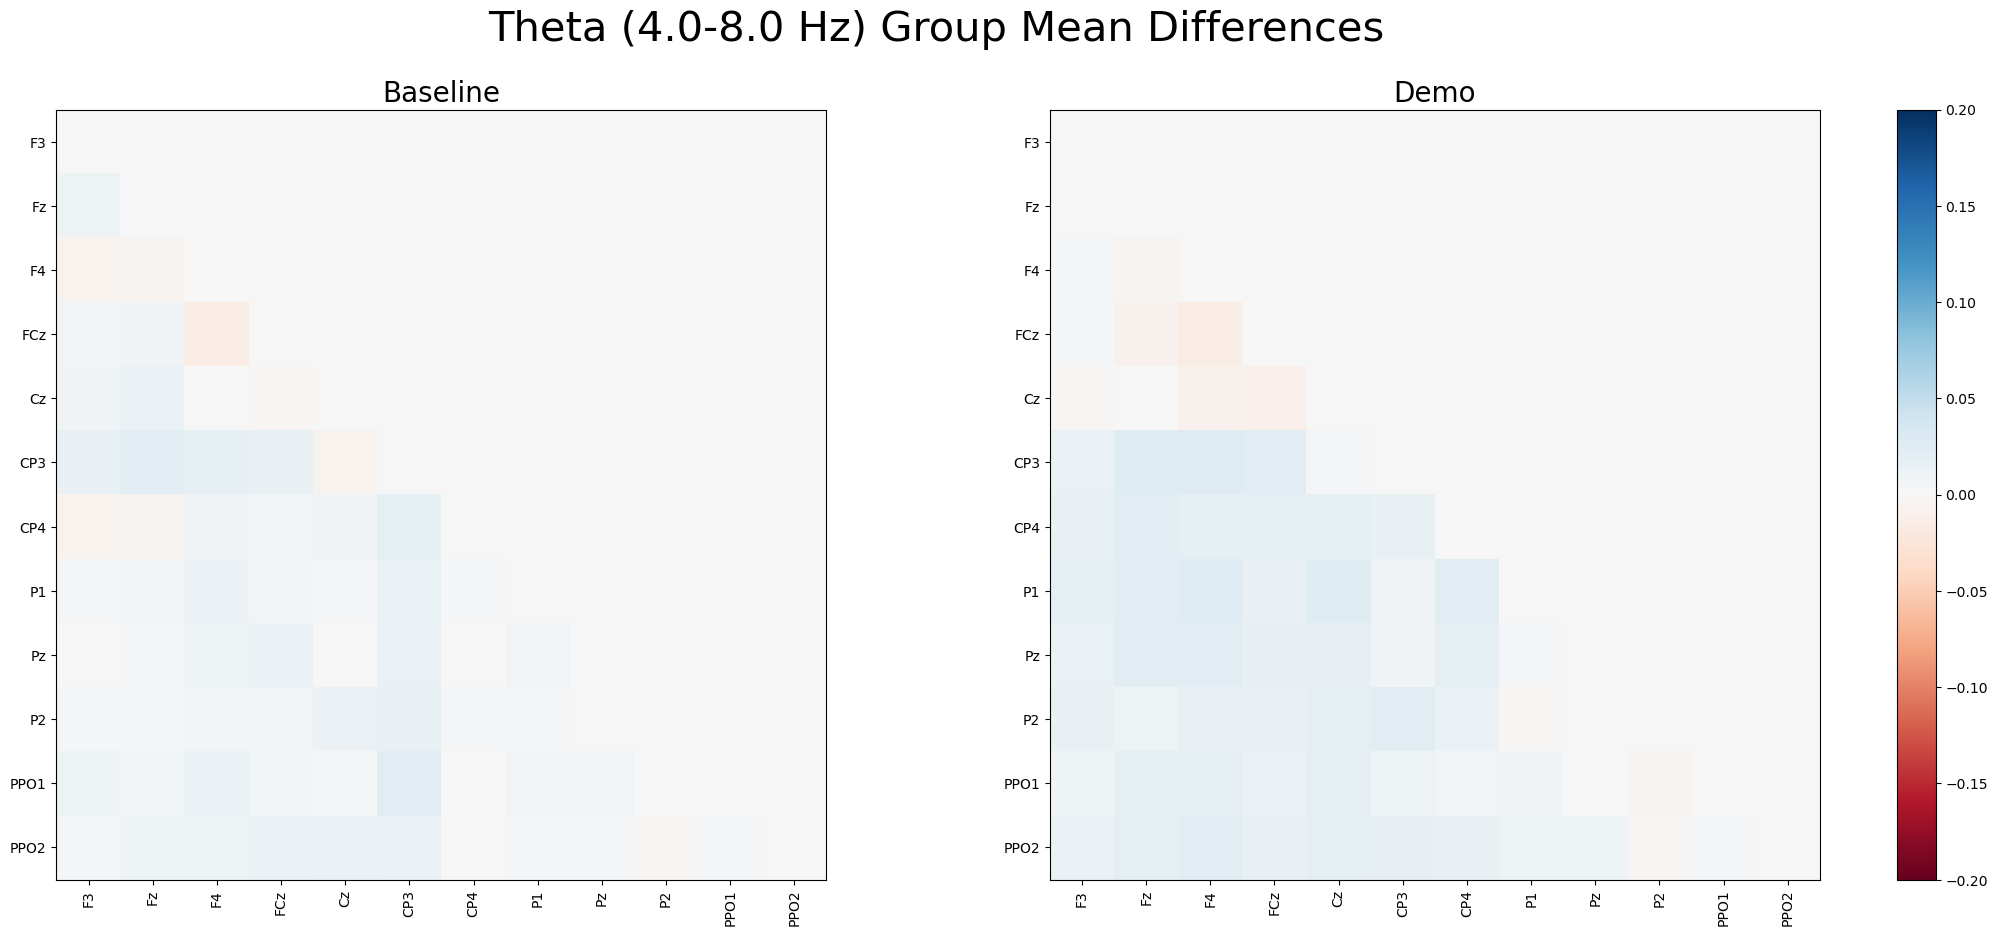

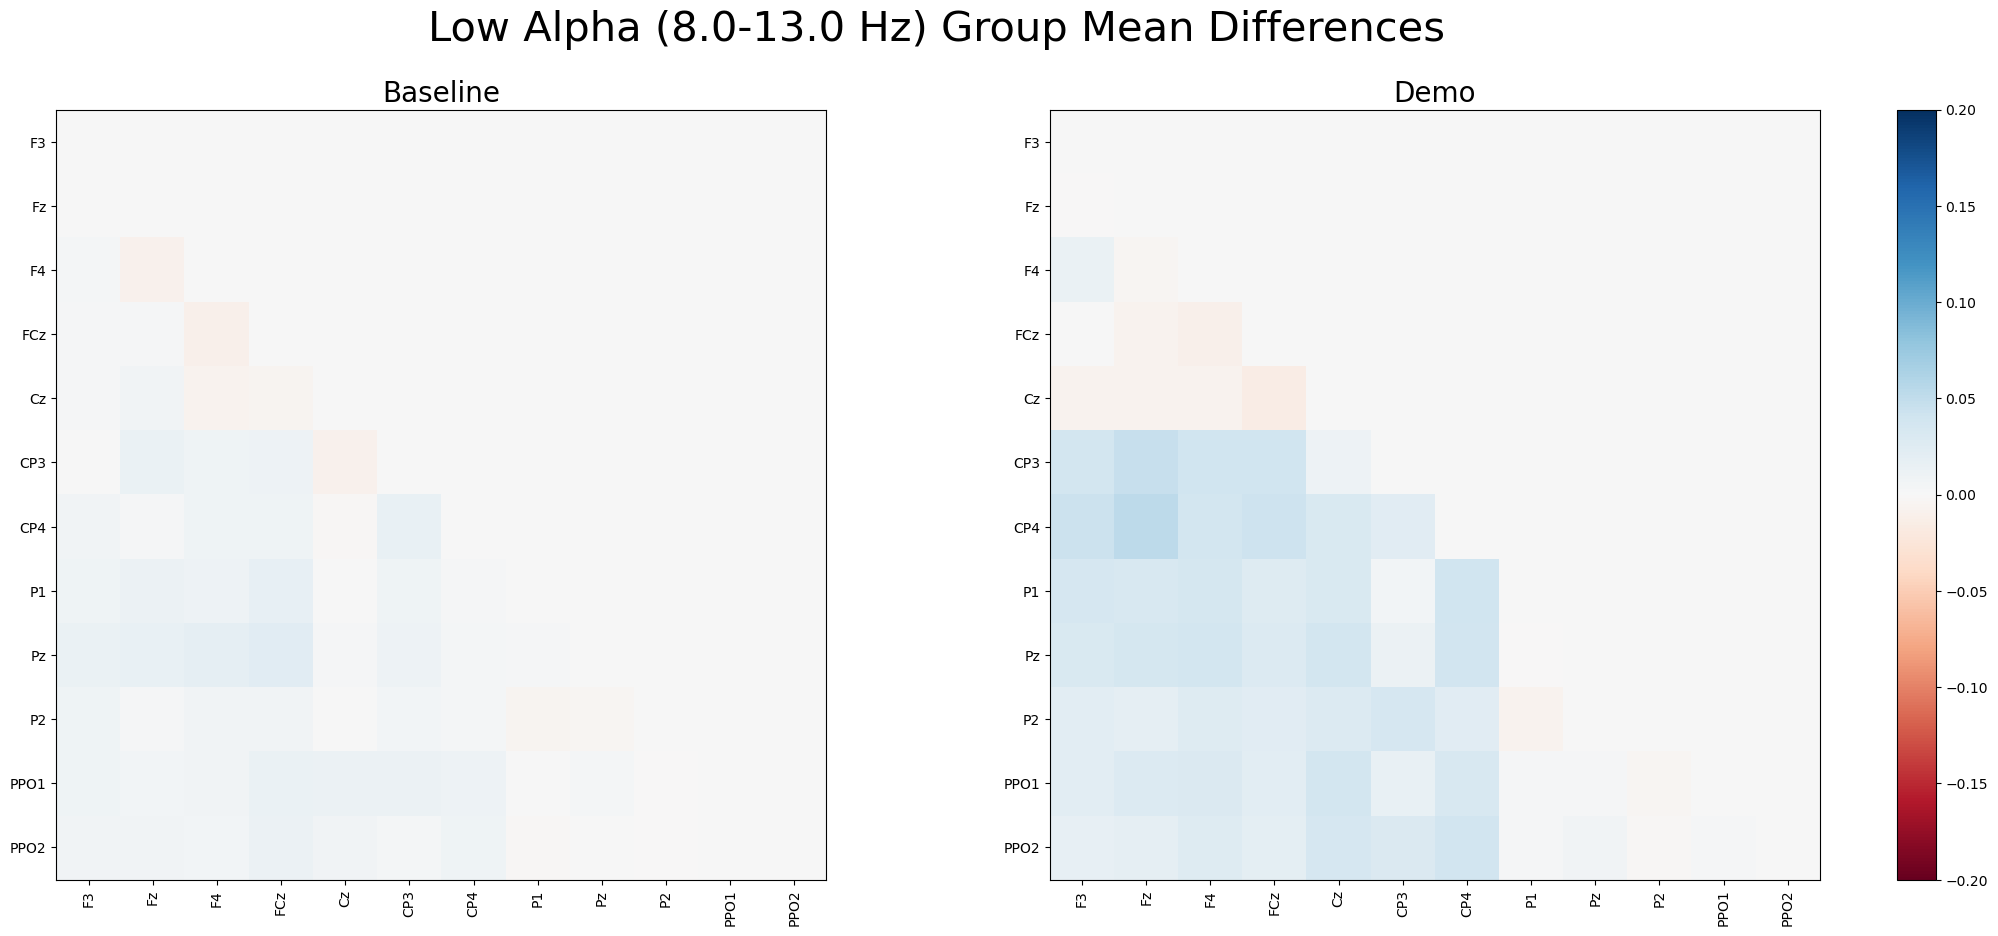

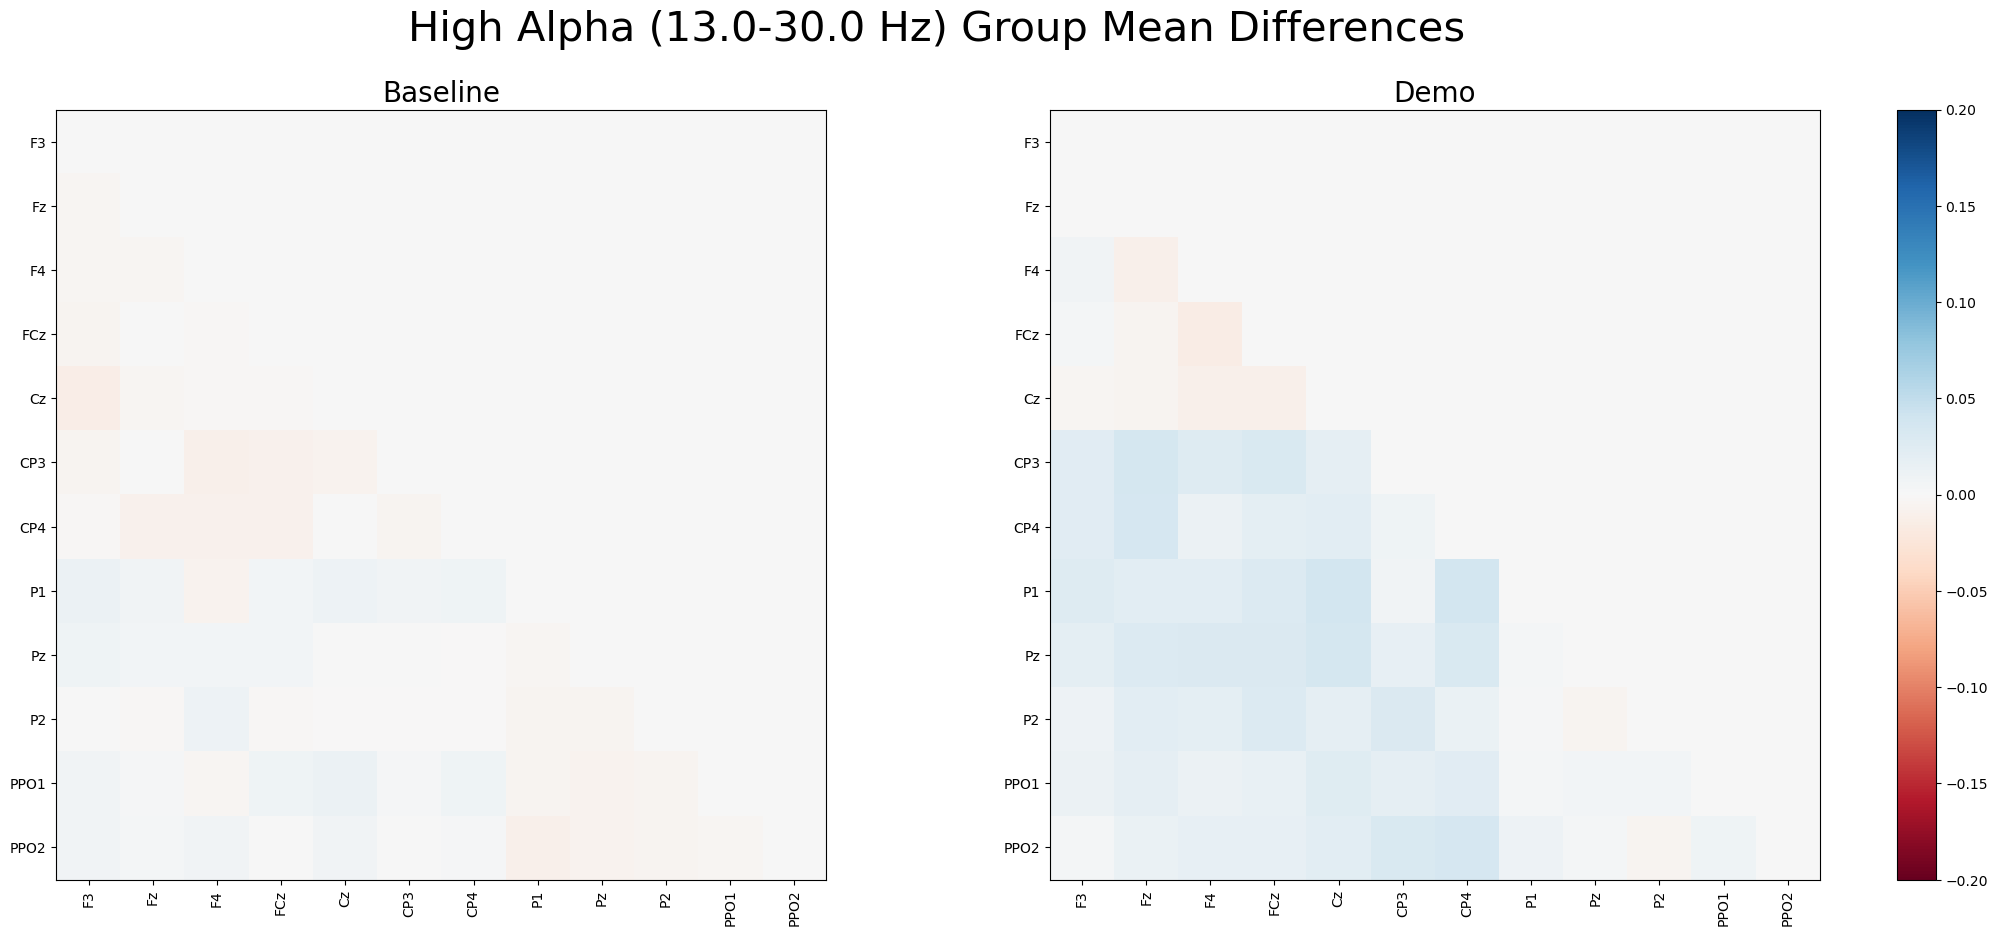

In [26]:
plot_diffs(delta_group_means, electrode_names, "Delta (0.5-4.0 Hz) Group Mean Differences")
plot_diffs(theta_group_means, electrode_names, "Theta (4.0-8.0 Hz) Group Mean Differences")
plot_diffs(low_alpha_group_means, electrode_names, "Low Alpha (8.0-13.0 Hz) Group Mean Differences")
plot_diffs(high_alpha_group_means, electrode_names, "High Alpha (13.0-30.0 Hz) Group Mean Differences")